In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import optimize
import utils

grader = utils.Grader()

%matplotlib inline

##Reference Links

https://stats.stackexchange.com/questions/94387/how-to-derive-errors-in-neural-network-with-the-backpropagation-algorithm/152159#152159?newreg=b82b1ebab8d3435b82c2f30822ed1f79

https://medium.com/@pdquant/all-the-backpropagation-derivatives-d5275f727f60
https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd

https://youtu.be/yXcQ4B-YSjQ

https://youtu.be/7bLEWDZng_M

In [ ]:
data = loadmat("ex4data1.mat")
# print(data)
X, y = data['X'], data['y'].ravel()

y[y==10] = 0
m = y.size

In [ ]:
def displayNumbers(data):
    if data.ndim == 2:
        m, n = data.shape
    else:
        m = 1
        n = data.size
        data = data[None]

    single_width = int(np.round(np.sqrt(n)))
    single_height = n/single_width

    rows = int(np.floor(np.sqrt(m)))
    cols = int(np.ceil(m/rows))

    fig, axes_arr = plt.subplots(rows, cols, figsize = (10, 10))
    fig.subplots_adjust(wspace=0.025, hspace=0.3)

    axes_arr = [axes_arr] if m == 1 else axes_arr.ravel()
    # print(data)
    for i, axs in enumerate(axes_arr):
        axs.imshow(data[i].reshape(single_width, single_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        axs.axis('off')

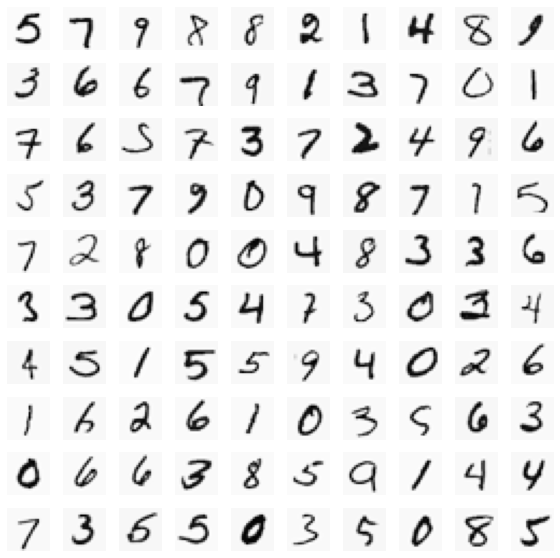

In [ ]:
rand_idx = np.random.choice(m, 100, replace = False)
rand_data = X[rand_idx, :]
displayNumbers(rand_data)

In [ ]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the weights into variables Theta1 and Theta2
weights = loadmat('ex4weights.mat')

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

In [ ]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [ ]:
def sigmoidGradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [ ]:
def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    """
    Implements the neural network cost function and gradient for a two layer neural 
    network which performs classification. 
    
    Parameters
    ----------
    nn_params : array_like
        The parameters for the neural network which are "unrolled" into 
        a vector. This needs to be converted back into the weight matrices Theta1
        and Theta2.
    
    input_layer_size : int
        Number of features for the input layer. 
    
    hidden_layer_size : int
        Number of hidden units in the second layer.
    
    num_labels : int
        Total number of labels, or equivalently number of units in output layer. 
    
    X : array_like
        Input dataset. A matrix of shape (m x input_layer_size).
    
    y : array_like
        Dataset labels. A vector of shape (m,).
    
    lambda_ : float, optional
        Regularization parameter.
 
    Returns
    -------
    J : float
        The computed value for the cost function at the current weight values.
    
    grad : array_like
        An "unrolled" vector of the partial derivatives of the concatenatation of
        neural network weights Theta1 and Theta2.
    
    Instructions
    ------------
    You should complete the code by working through the following parts.
    
    - Part 1: Feedforward the neural network and return the cost in the 
              variable J. After implementing Part 1, you can verify that your
              cost function computation is correct by verifying the cost
              computed in the following cell.
    
    - Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. After implementing Part 2, you can check
              that your implementation is correct by running checkNNGradients provided
              in the utils.py module.
    
              Note: The vector y passed into the function is a vector of labels
                    containing values from 0..K-1. You need to map this vector into a 
                    binary vector of 1's and 0's to be used with the neural network
                    cost function.
     
              Hint: We recommend implementing backpropagation using a for-loop
                    over the training examples if you are implementing it for the 
                    first time.
    
    - Part 3: Implement regularization with the cost function and gradients.
    
              Hint: You can implement this around the code for
                    backpropagation. That is, you can compute the gradients for
                    the regularization separately and then add them to Theta1_grad
                    and Theta2_grad from Part 2.
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))
    
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    # print(y_matrix)

    # Setup some useful variables
    m = y.size
         
    # You need to return the following variables correctly 
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)

    # ====================== YOUR CODE HERE ======================

    a1 = X.copy()

    a1 = np.concatenate([np.ones((m, 1)), a1], axis=1)

    a2 = sigmoid(a1.dot(Theta1.T))
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)

    a3 = sigmoid(a2.dot(Theta2.T))

    reg_term = (lambda_/(2*m))*(np.sum(np.square(Theta1[:, 1:]))+np.sum(np.square(Theta2[:, 1:])))

    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix))+reg_term
    
    # ================================================================
    # Unroll gradients
    # grad = np.concatenate([Theta1_grad.ravel(order=order), Theta2_grad.ravel(order=order)])

    #backpropagation
    delta_3 = a3 - y_matrix
    delta_2 = delta_3.dot(Theta2)[:, 1:] * sigmoidGradient(a1.dot(Theta1.T))
    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)
    

    Theta1_grad = (1 / m) * Delta1
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * Theta1[:, 1:]
    
    Theta2_grad = (1 / m) * Delta2
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * Theta2[:, 1:]

    grad = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, grad

In [ ]:
lambda_ = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
print('Cost at parameters (loaded from ex4weights): %.6f ' % J)
print('The cost should be about                   : 0.287629.')

Cost at parameters (loaded from ex4weights): 0.287629 
The cost should be about                   : 0.287629.


In [ ]:
grader = utils.Grader()
grader[1] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (deepesh.1905g2@gmail.com)? (Y/n): y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                       Regularized Gradient |  30 /  30 | Nice work!
              Feedforward and Cost Function |   0 /  15 | Your answer is incorrect.
                  Regularized Cost Function |   0 /   5 | Your answer is incorrect.
                           Sigmoid Gradient |   0 /  40 | Your answer is incorrect.
  Neural Network Gradient (Backpropagation) |   0 /  10 | Your answer is incorrect.
                                  --------------------------------
                                            |  30 / 100 |  



In [ ]:
# Weight regularization parameter (we set this to 1 here).
lambda_ = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                      num_labels, X, y, lambda_)

print('Cost at parameters (loaded from ex4weights): %.6f' % J)
print('This value should be about                 : 0.383770.')

Cost at parameters (loaded from ex4weights): 0.383770
This value should be about                 : 0.383770.


In [ ]:
grader[2] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (deepesh.1905g2@gmail.com)? (Y/n): y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                       Regularized Gradient |  30 /  30 | Nice work!
              Feedforward and Cost Function |  15 /  15 | Nice work!
                  Regularized Cost Function |   0 /   5 | Your answer is incorrect.
                           Sigmoid Gradient |   0 /  40 | Your answer is incorrect.
  Neural Network Gradient (Backpropagation) |   0 /  10 | Your answer is incorrect.
                                  --------------------------------
                                            |  45 / 100 |  



In [ ]:
z = np.array([-1, -0.5, 0, 0.5, 1])
g = sigmoidGradient(z)
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n  ')
print(g)

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:
  
[0.19661193 0.23500371 0.25       0.23500371 0.19661193]


In [ ]:
grader[3] = sigmoidGradient
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (deepesh.1905g2@gmail.com)? (Y/n): y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                       Regularized Gradient |  30 /  30 | Nice work!
              Feedforward and Cost Function |  15 /  15 | Nice work!
                  Regularized Cost Function |   5 /   5 | Nice work!
                           Sigmoid Gradient |   0 /  40 | Your answer is incorrect.
  Neural Network Gradient (Backpropagation) |   0 /  10 | Your answer is incorrect.
                                  --------------------------------
                                            |  50 / 100 |  



In [ ]:
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    """
    Randomly initialize the weights of a layer in a neural network.
    
    Parameters
    ----------
    L_in : int
        Number of incomming connections.
    
    L_out : int
        Number of outgoing connections. 
    
    epsilon_init : float, optional
        Range of values which the weight can take from a uniform 
        distribution.
    
    Returns
    -------
    W : array_like
        The weight initialiatized to random values.  Note that W should
        be set to a matrix of size(L_out, 1 + L_in) as
        the first column of W handles the "bias" terms.
        
    Instructions
    ------------
    Initialize W randomly so that we break the symmetry while training
    the neural network. Note that the first column of W corresponds 
    to the parameters for the bias unit.
    """

    W = np.zeros((L_out, 1 + L_in))

    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

In [ ]:
print('Initializing Neural Network Parameters ...')

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
print(initial_Theta1)
print(initial_Theta2)

# Unroll parameters
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Initializing Neural Network Parameters ...
[[ 0.11887508 -0.00494617  0.07366045 ... -0.09903703  0.05471351
   0.04571941]
 [ 0.1115174  -0.07095933  0.03115994 ...  0.06648869 -0.02273583
  -0.1194925 ]
 [-0.02845269  0.09778412  0.00198581 ...  0.04354383  0.04284612
   0.11714681]
 ...
 [ 0.01759045 -0.02176666 -0.10824329 ...  0.11388089 -0.11605955
  -0.00826247]
 [ 0.07968057 -0.04929306  0.01604664 ... -0.02496916  0.11418399
   0.08555499]
 [-0.08012596 -0.02160541 -0.02064469 ... -0.11010445  0.03228817
   0.10936028]]
[[ 1.35604397e-02 -3.42693950e-02 -2.80784341e-02  9.97019269e-02
  -9.14739253e-02  1.33856771e-03 -1.07452369e-01 -5.04218158e-02
  -9.07182356e-03 -1.11641146e-01 -7.23769248e-02 -8.36399022e-03
   8.51067876e-02  3.08716714e-02  6.10448712e-02  6.47947341e-02
  -8.95438900e-02 -6.65380801e-02  5.08494642e-02 -1.02880130e-01
  -9.64395789e-02 -4.54117219e-02  3.64109052e-02 -6.84651143e-02
  -6.78992955e-02  4.85169784e-02]
 [-1.15948944e-01  2.08517308e-02 

In [ ]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(Theta1, Theta2)
    """
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p


def debugInitializeWeights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in incoming connections and fan_out outgoings
    connections using a fixed strategy. This will help you later in debugging.

    Note that W should be set a matrix of size (1+fan_in, fan_out) as the first row of W handles
    the "bias" terms.

    Parameters
    ----------
    fan_out : int
        The number of outgoing connections.

    fan_in : int
        The number of incoming connections.

    Returns
    -------
    W : array_like (1+fan_in, fan_out)
        The initialized weights array given the dimensions.
    """
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    print(W)
    return W

In [ ]:
def computeNumericalGradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.

    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.

    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.

    e : float (optional)
        The value to use for epsilon for computing the finite difference.

    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    print("perturb: ")
    print(perturb)
    print('-------------------')
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad


In [ ]:
def checkNNGradients(nnCostFunction, lambda_=0):
    """
    Creates a small neural network to check the backpropagation gradients. It will output the
    analytical gradients produced by your backprop code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result in
    very similar values.

    Parameters
    ----------
    nnCostFunction : func
        A reference to the cost function implemented by the student.

    lambda_ : float (optional)
        The regularization parameter value.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two the solutions. If you have a correct
    # implementation, and assuming you used e = 0.0001 in computeNumericalGradient, then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    print('If your backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n'
          'Relative Difference: %g' % diff)
checkNNGradients(nnCostFunction)

[[ 0.0841471  -0.02794155 -0.09999902 -0.02879033]
 [ 0.09092974  0.06569866 -0.05365729 -0.09613975]
 [ 0.014112    0.09893582  0.0420167  -0.07509872]
 [-0.07568025  0.04121185  0.09906074  0.01498772]
 [-0.09589243 -0.05440211  0.06502878  0.09129453]]
[[ 0.0841471  -0.07568025  0.06569866 -0.05440211  0.0420167  -0.02879033]
 [ 0.09092974 -0.09589243  0.09893582 -0.09999902  0.09906074 -0.09613975]
 [ 0.014112   -0.02794155  0.04121185 -0.05365729  0.06502878 -0.07509872]]
[[ 0.0841471  -0.02794155 -0.09999902]
 [ 0.09092974  0.06569866 -0.05365729]
 [ 0.014112    0.09893582  0.0420167 ]
 [-0.07568025  0.04121185  0.09906074]
 [-0.09589243 -0.05440211  0.06502878]]
perturb: 
[[0.0001 0.     0.     ... 0.     0.     0.    ]
 [0.     0.0001 0.     ... 0.     0.     0.    ]
 [0.     0.     0.0001 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.0001 0.     0.    ]
 [0.     0.     0.     ... 0.     0.0001 0.    ]
 [0.     0.     0.     ... 0.     0.     0.0001]]
------------

In [ ]:
grader[4] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (deepesh.1905g2@gmail.com)? (Y/n): n
Login (email address): deepesh.1905g2@gmail.com
Token: pdYOMiwa6GyJUpaf
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                       Regularized Gradient |  30 /  30 | Nice work!
              Feedforward and Cost Function |  15 /  15 | Nice work!
                  Regularized Cost Function |   5 /   5 | Nice work!
                           Sigmoid Gradient |  40 /  40 | Nice work!
  Neural Network Gradient (Backpropagation) |   0 /  10 | Your answer is incorrect.
                                  --------------------------------
                                            |  90 / 100 |  



In [ ]:
#  Check gradients by running checkNNGradients
lambda_ = 3
utils.checkNNGradients(nnCostFunction, lambda_)

# Also output the costFunction debugging values
debug_J, _  = nnCostFunction(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lambda_)

print('\n\nCost at (fixed) debugging parameters (w/ lambda = %f): %f ' % (lambda_, debug_J))
print('(for lambda = 3, this value should be about 0.576051)')

[[-9.27825235e-03 -9.27825236e-03]
 [-1.67679797e-02 -1.67679797e-02]
 [-6.01744725e-02 -6.01744725e-02]
 [-1.73704651e-02 -1.73704651e-02]
 [ 8.89911959e-03  8.89911960e-03]
 [ 3.94334829e-02  3.94334829e-02]
 [-3.19612287e-02 -3.19612287e-02]
 [-5.75658668e-02 -5.75658668e-02]
 [-8.36010761e-03 -8.36010762e-03]
 [ 5.93355565e-02  5.93355565e-02]
 [ 2.49225535e-02  2.49225535e-02]
 [-4.51963845e-02 -4.51963845e-02]
 [ 7.62813550e-03  7.62813551e-03]
 [ 2.47640974e-02  2.47640974e-02]
 [ 5.97717617e-02  5.97717617e-02]
 [ 9.14587966e-03  9.14587966e-03]
 [-6.74798369e-03 -6.74798370e-03]
 [-3.26881426e-02 -3.26881426e-02]
 [ 3.86410548e-02  3.86410548e-02]
 [ 5.46101547e-02  5.46101547e-02]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.18682669e-01  1.18682669e-01]
 [ 2.03987128e-01  2.03987128e-01]
 [ 1.25698067e-01  1.25698067e-01]
 [ 1.76337550e-01  1.76337550e-01]
 [ 1.32294136e-01  1.32294136e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 3.81928689e-05  3.81928696e-05]
 [ 1.17148233e-01  1

In [ ]:
grader[5] = nnCostFunction
grader.grade()


Submitting Solutions | Programming Exercise neural-network-learning

Use token from last successful submission (deepesh.1905g2@gmail.com)? (Y/n): y
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
                       Regularized Gradient |  30 /  30 | Nice work!
              Feedforward and Cost Function |  15 /  15 | Nice work!
                  Regularized Cost Function |   5 /   5 | Nice work!
                           Sigmoid Gradient |  40 /  40 | Nice work!
  Neural Network Gradient (Backpropagation) |  10 /  10 | Nice work!
                                  --------------------------------
                                            | 100 / 100 |  



In [ ]:
#  After you have completed the assignment, change the maxiter to a larger
#  value to see how more training helps.
options= {'maxiter': 400}

#  You should also try different values of lambda
lambda_ = 1.5

# Create "short hand" for the cost function to be minimized
costFunction = lambda p: nnCostFunction(p, input_layer_size,
                                        hidden_layer_size,
                                        num_labels, X, y, lambda_)

# Now, costFunction is a function that takes in only one argument
# (the neural network parameters)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)

# get the solution of the optimization
nn_params = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, (input_layer_size + 1)))

Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size + 1)))

In [ ]:
pred = utils.predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 99.000000


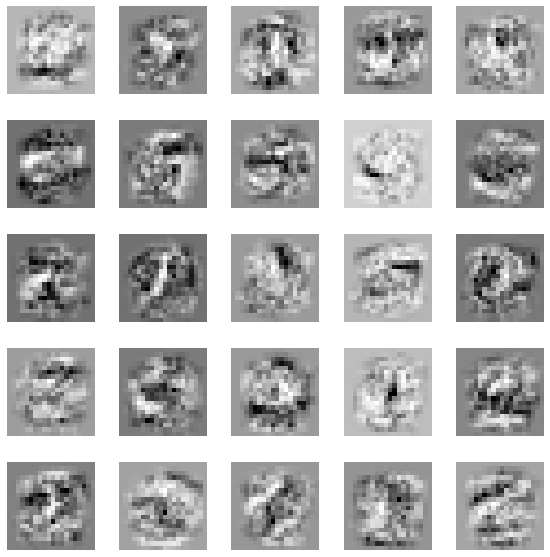

In [ ]:
displayNumbers(Theta1[:, 1:])